# Imports

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# Seaborn
import seaborn as sns
import seaborn as sns

# Sci-kit learn
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Input
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.optimizers import SGD
from keras.models import Model

from PIL import ImageFile                            

# Load the data

In [2]:
# Create path constants
DATA_DIR = r"state-farm-distracted-driver-detection/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"basic_model_aug")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [3]:
# Create the specified directories (if it does not exist)
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

Model path does not exists
Model path created


# Create data CSVs

In [4]:
def create_csv(DATA_DIR, filename):
    # Get the classes
    class_names = os.listdir(DATA_DIR)
    data = list()
    # Check if the class data folder is found if not we are in test directory
    if(os.path.isdir(os.path.join(DATA_DIR, class_names[0]))):
        # iterate through the classes
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR, class_name))
            for file in file_names:
                data.append({
                    "filename": os.path.join(DATA_DIR,class_name,file),
                    "classname": class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "filename": os.path.join(DATA_DIR,file),
                "classname": class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(), "csv_files", filename), index=False)

In [5]:
# Create CSVs for train and test
create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
# Load the train and test CSVs
data_train = pd.read_csv(os.path.join(os.getcwd(), "csv_files", "train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(), "csv_files", "test.csv"))

## Data visualization

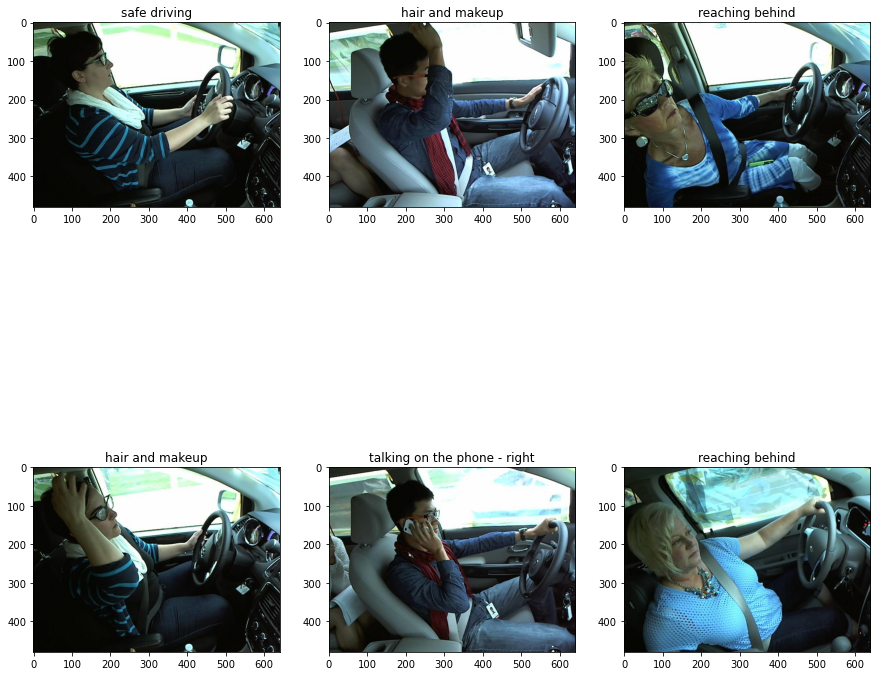

In [6]:
classes = {"c0": "safe driving",
           "c1": "texting - right",
           "c2": "talking on the phone - right",
           "c3": "texting - left",
           "c4": "talking on the phone - left",
           "c5": "operating the radio",
           "c6": "drinking",
           "c7": "reaching behind",
           "c8": "hair and makeup",
           "c9": "talking to passenger"
          }
# Take a random sample of the daفa
df = data_train.sample(frac=1).reset_index(drop=True)
plt.figure(figsize=(15, 15))
for i, row in df.iterrows():
    img_path = row.values[0]
    img = image.load_img(img_path)
    ax = plt.subplot(int(f"23{i+1}"))
    ax.margins(0.05)
    ax.imshow(img)
    label = row.values[1]
    label = classes[label]
    ax.set_title(label)
    if i > 4:
        break
plt.savefig(os.path.join(MODEL_PATH, "data_visualization_basic.png"))
plt.show()


## Data exploration

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   22424 non-null  object
 1   classname  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [8]:
data_train['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [9]:
data_train.describe()

,filename,classname
count,22424,22424
unique,22424,10
top,state-farm-distracted-driver-detection/imgs\tr...,c0
freq,1,2489


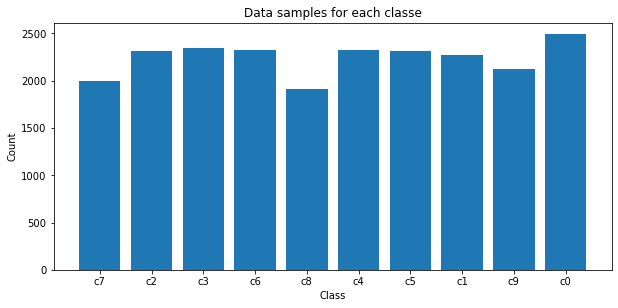

In [10]:
# Create a bar chart for the data samples for each class
nf = data_train['classname'].value_counts(sort=False)
labels = data_train['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
x = range(len(y))
# Create figure
fig = plt.figure(figsize=(10, 10))
ay = fig.add_subplot(211)
plt.xticks(x, labels)
ay.bar(x, y)
plt.title('Data samples for each classe')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig(os.path.join(MODEL_PATH, "data_samples_per_class.png"))
plt.show()

We can see that the training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data.

In [11]:
data_test.head()

,filename,classname
0,state-farm-distracted-driver-detection/imgs\te...,test
1,state-farm-distracted-driver-detection/imgs\te...,test
2,state-farm-distracted-driver-detection/imgs\te...,test
3,state-farm-distracted-driver-detection/imgs\te...,test
4,state-farm-distracted-driver-detection/imgs\te...,test


In [12]:
print(f"There are total {data_train.shape[0]} training samples")
print(f"There are total {data_test.shape[0]} testing samples")

There are total 22424 training samples
There are total 79726 testing samples


# Data preprocessing

### 1. Convert the labels to numerals

In [13]:
labels_list = list(set(data_train['classname'].values.tolist()))
labels_id = {label_name:id for id, label_name in enumerate(labels_list)}
print(f"labels_id = {labels_id}")
data_train['classname'].replace(labels_id, inplace=True)

labels_id = {'c6': 0, 'c3': 1, 'c9': 2, 'c5': 3, 'c2': 4, 'c4': 5, 'c7': 6, 'c1': 7, 'c8': 8, 'c0': 9}


### 2. Splitting training data into train and test (validation) sets

In [14]:
# Split the data into 80% train and 20% test
data_train['classname'] = data_train['classname'].astype(str)
split = np.random.rand(len(data_train)) < 0.8
train_df = data_train[split]
test_df = data_train[~split]

### 3. Data augmentation

In [15]:
batch_size = 32
target_size = (64, 64)
# Create the training data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col="filename",
                                                    y_col="classname",
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")



Found 18018 validated image filenames belonging to 10 classes.


Applying scaling, shear, zoom, and horizontal flip augmentation techniques


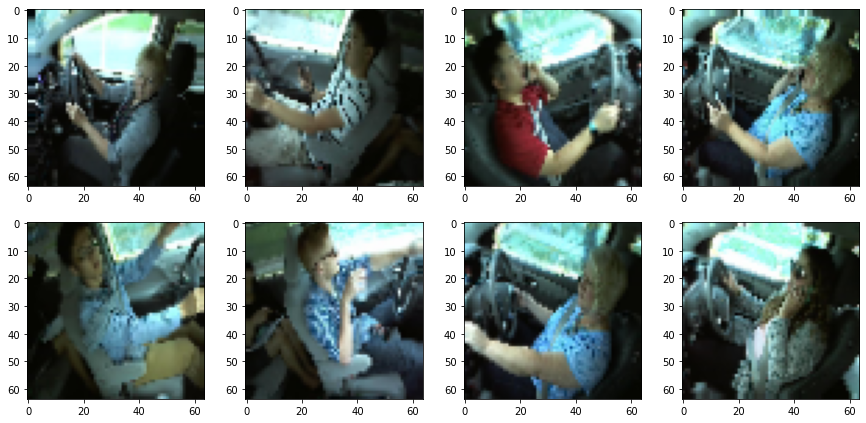

In [16]:
print("Applying scaling, shear, zoom, and horizontal flip augmentation techniques")
plt.figure(figsize=(15, 15))
for i in range(8):
    img, label = train_generator.next()
    ax = plt.subplot(int(f"44{i+1}"))
    ax.margins(0.05)
    ax.imshow(img[0])
plt.savefig(os.path.join(MODEL_PATH, "data_augmentation.png"))
plt.show()

In [17]:
# Create the validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(test_df,
                                                        x_col="filename",
                                                        y_col="classname",
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Found 4406 validated image filenames belonging to 10 classes.


# Building the Model

In [18]:
input_shape = (64, 64, 3)
kernel_initializer = 'glorot_normal'
padding = 'same'
activation = 'relu'

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding=padding, activation=activation, 
                 input_shape=input_shape, kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=3, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation=activation, kernel_initializer=kernel_initializer))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax', kernel_initializer=kernel_initializer))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1

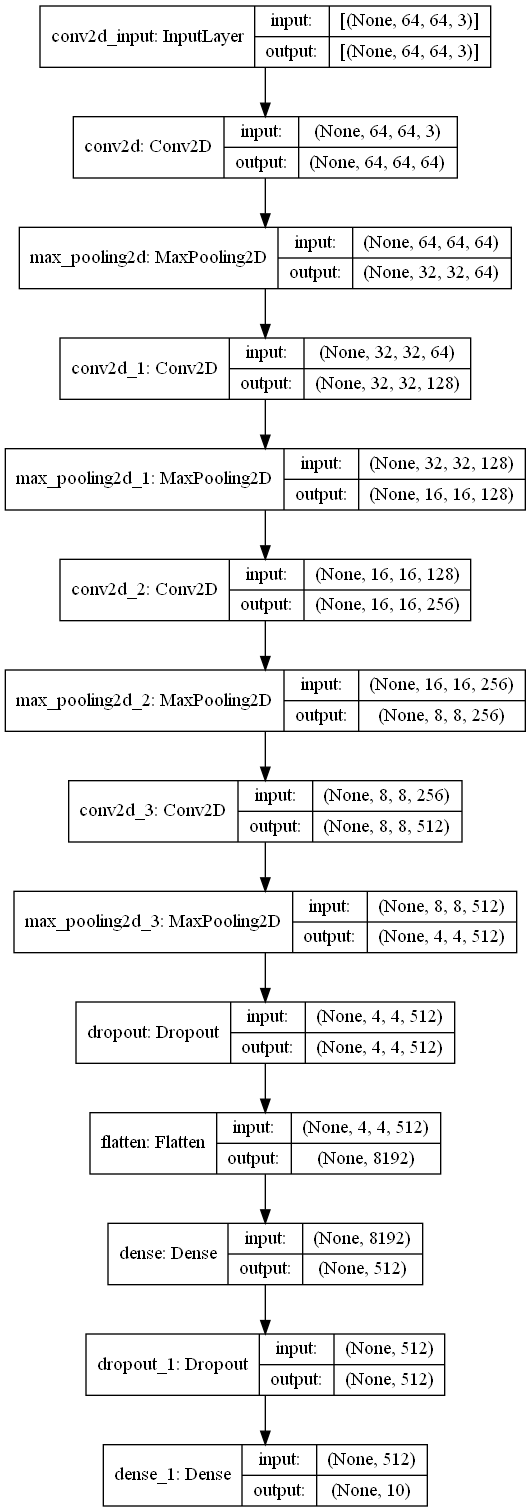

In [19]:
# Plot the model
plot_model(model, to_file=os.path.join(MODEL_PATH, "basic_distraction_model_aug.png"), show_shapes=True, show_layer_names=True)

In [20]:
# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
steps_per_epoch = train_df.shape[0] / batch_size
validation_steps = test_df.shape[0] / batch_size
epochs = 2
# Save the model with the best accuracy during the training process
filepath = os.path.join(MODEL_PATH, "distraction-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]

# Start the training process
model_history = model.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=validation_steps,
                          callbacks=callbacks_list)

Epoch 1/2
563/563 [==============================] - 204s 361ms/step - loss: 2.0367 - accuracy: 0.2596 - val_loss: 0.5183 - val_accuracy: 0.8291

Epoch 00001: val_accuracy improved from -inf to 0.82910, saving model to C:\Users\asebaq\distraction-detection\basic_model_aug\distraction-01-0.83.hdf5
Epoch 2/2
563/563 [==============================] - 206s 365ms/step - loss: 0.4493 - accuracy: 0.8522 - val_loss: 0.3798 - val_accuracy: 0.8815

Epoch 00002: val_accuracy improved from 0.82910 to 0.88153, saving model to C:\Users\asebaq\distraction-detection\basic_model_aug\distraction-02-0.88.hdf5


# Plot performance graphs

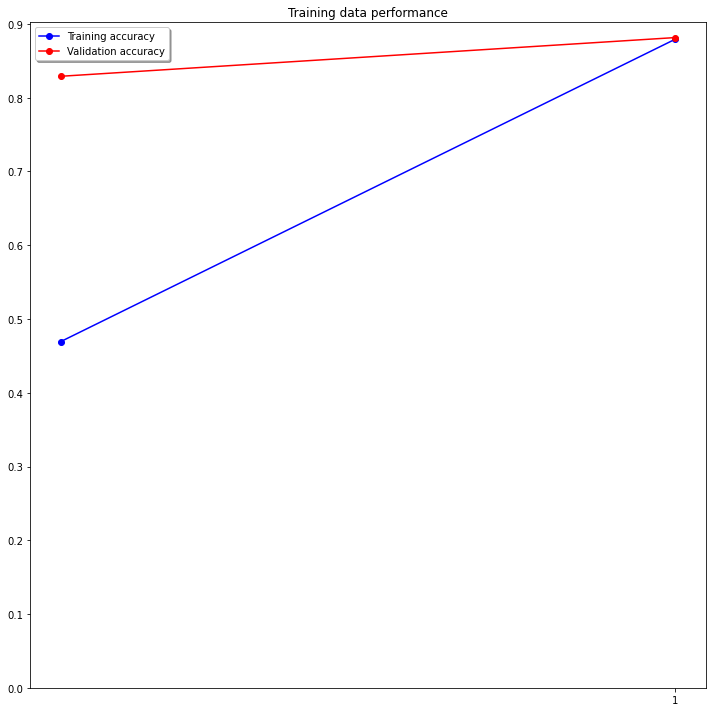

In [22]:
# Training date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['accuracy'], '-bo', label="Training accuracy")
plt.plot(model_history.history['val_accuracy'], '-ro',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Training data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_aug_training.png"))
plt.show()


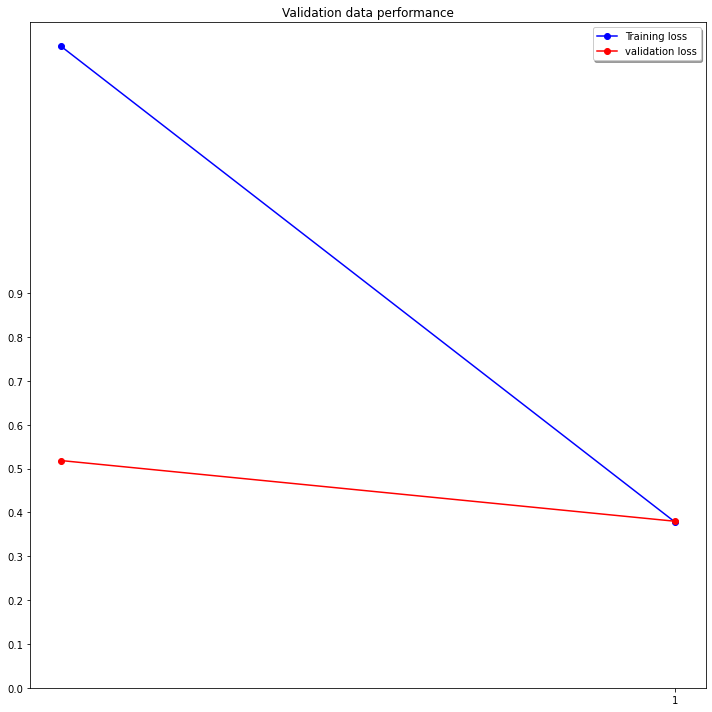

In [23]:
# Validation date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['loss'], '-bo', label="Training loss")
plt.plot(model_history.history['val_loss'], '-ro', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Validation data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_aug_validation.png"))

plt.show()

# Model Analysis
Finding the Confusion matrix, Precision, Recall and F1 score to analyse the model performance 

In [24]:
def show_confusion_matrix(confusion_matrix, class_names):
    figsize = (10,10)
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH, "basic_model_aug_confusion_matrix.png"))
    plt.show()
    return fig

def show_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions
    matrix = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis=1)
    w, h = matrix.shape
    c_m = np.zeros((w, h))
    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]
    c = c_m.astype(dtype=np.uint8)
    heatmap = show_confusion_matrix(c, class_names)

In [25]:
class_names = list()
for name, idx in labels_id.items():
    class_names.append(name)


In [26]:
# Create the validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(test_df,
                                                        x_col="filename",
                                                        y_col="classname",
                                                        target_size=target_size,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        class_mode='categorical')
y_pred = model.predict(validation_generator)

Found 4406 validated image filenames belonging to 10 classes.


In [27]:
y_test = test_df["classname"].apply(int)
y_test = np.asarray(list(y_test)).reshape((-1, 1))
y_test = to_categorical(y_test)

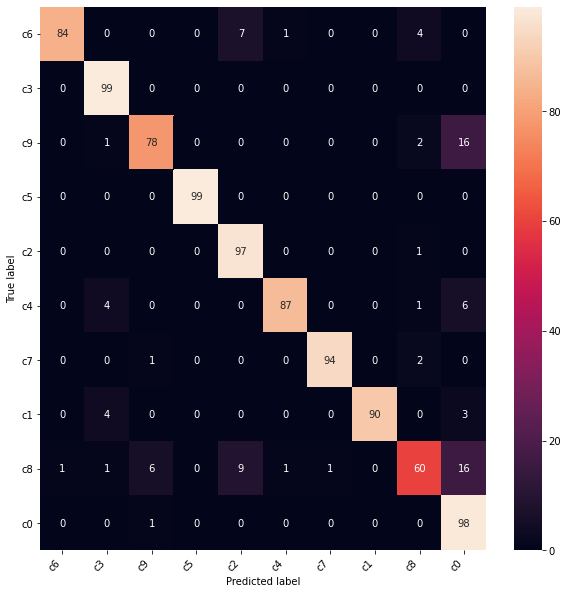

In [28]:
show_heatmap(y_pred, y_test, class_names)

In [29]:
result = model.evaluate(validation_generator)
print(f"Loss: {round(result[0], 5)}")
print(f"Accuracy: {round(result[1]*100, 3)} %")

4406/4406 [==============================] - 29s 7ms/step - loss: 0.3798 - accuracy: 0.8815
Loss: 0.37985
Accuracy: 88.153 %


# Precision, recall, and F1 score

In [30]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")

# precision = tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {round(precision, 3)}")

# recall = tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {round(recall, 3)}")

# f1 = 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {round(f1, 3)}")

Accuracy: 0.882
Precision: 0.9
Recall: 0.882
F1 score: 0.88


# Use predefined models
We are also using transfer learning and fine tuning 

## InceptionV3

In [31]:
MODEL_PATH = os.path.join(os.getcwd(),"inception_v3")
os.makedirs(MODEL_PATH, exist_ok=True)

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

# create the base pre-trained model
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 32
target_size = (224, 224)
# Create the training data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col="filename",
                                                    y_col="classname",
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

# Create the validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_dataframe(test_df,
                                                        x_col="filename",
                                                        y_col="classname",
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

steps_per_epoch = train_df.shape[0] / batch_size
validation_steps = test_df.shape[0] / batch_size
epochs = 2
# Save the model with the best accuracy during the training process
filepath = os.path.join(MODEL_PATH, "distraction-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]
# train the model on the new data for a few epochs
model_history = model.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=validation_steps,
                          callbacks=callbacks_list)


Found 18018 validated image filenames belonging to 10 classes.
Found 4406 validated image filenames belonging to 10 classes.
Epoch 1/2
563/563 [==============================] - 590s 1s/step - loss: 3.0554 - accuracy: 0.3578 - val_loss: 0.7817 - val_accuracy: 0.7240

Epoch 00001: val_accuracy improved from -inf to 0.72401, saving model to C:\Users\asebaq\distraction-detection\inception_v3\distraction-01-0.72.hdf5
Epoch 2/2
563/563 [==============================] - 589s 1s/step - loss: 0.7955 - accuracy: 0.7243 - val_loss: 0.4732 - val_accuracy: 0.8479

Epoch 00002: val_accuracy improved from 0.72401 to 0.84793, saving model to C:\Users\asebaq\distraction-detection\inception_v3\distraction-02-0.85.hdf5


In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
    
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
epochs = 2
model_history = model.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=validation_steps,
                          callbacks=callbacks_list)

Epoch 1/2
563/563 [==============================] - 761s 1s/step - loss: 1.2005 - accuracy: 0.6132 - val_loss: 0.4856 - val_accuracy: 0.8824

Epoch 00001: val_accuracy improved from 0.84793 to 0.88243, saving model to C:\Users\asebaq\distraction-detection\inception_v3\distraction-01-0.88.hdf5
Epoch 2/2
464/563 [=======================>......] - ETA: 1:51 - loss: 0.4931 - accuracy: 0.8793

# Plot performance graphs

In [ ]:
# Training date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['accuracy'], '-bo', label="Training accuracy")
plt.plot(model_history.history['val_accuracy'], '-ro',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Training data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "inceptionv3_model_training.png"))
plt.show()


In [ ]:
# Validation date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['loss'], '-bo', label="Training loss")
plt.plot(model_history.history['val_loss'], '-ro', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Validation data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "inceptionv3_model_validation.png"))
plt.show()

# InceptionV3 model analysis

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
    figsize = (10,10)
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH, "inceptionv3_aug_confusion_matrix.png"))
    plt.show()
    return fig

def show_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions
    matrix = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis=1)
    w, h = matrix.shape
    c_m = np.zeros((w, h))
    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]
    c = c_m.astype(dtype=np.uint8)
    heatmap = show_confusion_matrix(c, class_names)
    
# Create the validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(test_df,
                                                        x_col="filename",
                                                        y_col="classname",
                                                        target_size=target_size,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        class_mode='categorical')
y_pred = model.predict(validation_generator)
y_test = test_df["classname"].apply(int)
y_test = np.asarray(list(y_test)).reshape((-1, 1))
y_test = to_categorical(y_test)
show_heatmap(y_pred, y_test, class_names)
result = model.evaluate(validation_generator)
print(f"Loss: {round(result[0], 5)}")
print(f"Accuracy: {round(result[1]*100, 3)} %")

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")

# precision = tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {round(precision, 3)}")

# recall = tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {round(recall, 3)}")

# f1 = 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {round(f1, 3)}")

In [ ]:
classes = {"c0": "safe driving",
           "c1": "texting - right",
           "c2": "talking on the phone - right",
           "c3": "texting - left",
           "c4": "talking on the phone - left",
           "c5": "operating the radio",
           "c6": "drinking",
           "c7": "reaching behind",
           "c8": "hair and makeup",
           "c9": "talking to passenger"
          }

plt.figure(figsize=(15, 15))
for i, img_path in data_test.iterrows():
    img_path = img_path.values[0]
    img = image.load_img(img_path)
    ax = plt.subplot(int(f"44{i+1}"))
    ax.margins(0.05)
    ax.imshow(img)
    img_tensor = path_to_tensor(img_path).astype('float32')/255
    label = np.argmax(model.predict(img_tensor))
    label = classes[labels_list[label]]
    ax.set_title(label)
    if i > 6:
        break
plt.savefig(os.path.join(MODEL_PATH, "basic_model_test_samples.png"))
plt.show()


### We can also try to use ResNet50V2, MobileNetV2, or VGG16. 
### And may be do an ensambled model which will combine all of these.